In [1]:
#|default_exp tmp

# Upscale multiarch

In [29]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.challange.ct94ep5 import *
from miniai.utils import *
from miniai.accel import *
import timm

In [3]:
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = False 

In [4]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [125]:
RNG = RNGSeedCB(verbose=True)
RNG.set_seed(1)

Reseed: 1


1

In [126]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)

  0%|          | 0/2 [00:00<?, ?it/s]

In [127]:
tds.cached = cache_dataset_as_dict(tds)

In [145]:
metrics = LazyMetricsCB(accuracy=MulticlassAccuracy())

def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=AccelerateCB(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=False, 
        sched_fn=lr_scheduler.OneCycleLR, opt_func=optim.AdamW):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds.cached, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(sched_fn, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), RNG, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=opt_func)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), LazyProgressCB(plot=epochs>1)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        print('TTA:', round((ap==at).float().mean().item(), 4))
    return learn

In [75]:
#| export
class Upscale:
    def __init__(self, sz, align=True, const=0): fc.store_attr() 
    def _sz(self, n): return round(self.sz*n / 32)*32 if self.align else self.sz*n
    def antialiased(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=True)
    def bilinear(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.BILINEAR, antialias=False)
    def nearest(self, n): 
        return transforms.Resize(self._sz(n), transforms.InterpolationMode.NEAREST)
    def pad(self, n): 
        return transforms.Pad((self._sz(n)-self.sz)//2, padding_mode='constant', fill=self.const)

In [76]:
upscale32 = Upscale(28, align=True, const=-0.800000011920929)
upscale = Upscale(28, align=False, const=-0.800000011920929)

In [77]:
RNG.previous()
learn = run(get_model(), epochs=1)
xb,yb = learn.batch

Batch size 256


accuracy,loss,epoch,train
0.795,0.578,0,train
0.858,0.375,0,eval


Fit 1 in: 1.42s, setup: 0.01s, 1.37 ± 0.00s per epoch, 0.00 ± 0.00s per batch


In [78]:
xb.shape, upscale32.bilinear(4)(xb).shape,upscale32.pad(4)(xb).shape

(torch.Size([272, 1, 28, 28]),
 torch.Size([272, 1, 128, 128]),
 torch.Size([272, 1, 128, 128]))

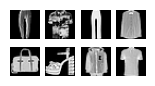

In [79]:
def show_actual_size(ims):
    sz = ims.shape[-1]
    show_images(ims, imsize=sz / 64)
show_actual_size(xb[:8])

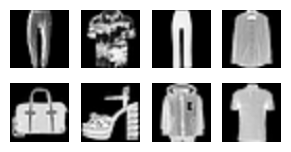

In [80]:
show_actual_size(upscale.bilinear(2)(xb)[:8])

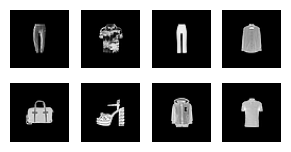

In [81]:
show_actual_size(upscale.pad(2)(xb)[:8])

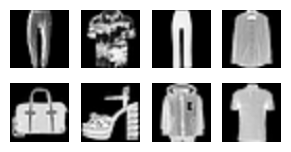

In [82]:
show_actual_size(upscale.antialiased(2)(xb)[:8])

### Timm model upscale, pad, vs noop

> Changes in batchsize does not have any significant impact on training speed

In [83]:
#| export
def timm_model(name, resize=nn.Identity(), **kw):
    RNG.previous()
    props = dict(in_chans=1, num_classes=10, pretrained=False)
    props.update(kw)
    model = nn.Sequential( 
        resize,
        timm.create_model(name, **props)
    )
    return dict(model=model)

In [106]:
# Cristopher Thomas 94.9% 5epochs
def model9_ct(**kw):
    from miniai.challange.ct94ep5 import get_model9
    RNG.previous()
    return dict(model=get_model9(Mish, norm=nn.BatchNorm2d), base_lr=1e-2, leaky=0.0003) | kw

In [98]:
# The last resnet model 92.8% 5epochs
def model_base_resnet():
    from miniai.resnet import get_model
    RNG.previous()
    return dict(model=get_model(act_gr, norm=nn.BatchNorm2d))

In [94]:
learn = run(**timm_model('resnet18d', nn.Identity()), leaky=0.0, epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.833,0.461,0,train
0.895,0.286,0,eval


Fit 1 in: 5.49s, setup: 0.00s, 5.35 ± 0.00s per epoch, 0.02 ± 0.00s per batch


In [92]:
learn = run(**timm_model('resnet18d', upscale32.pad(2)), leaky=0.0, epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.824,0.488,0,train
0.891,0.297,0,eval


Fit 1 in: 7.62s, setup: 0.00s, 7.38 ± 0.00s per epoch, 0.03 ± 0.02s per batch


In [93]:
learn = run(**timm_model('resnet18d', upscale32.nearest(2)), leaky=0.0, epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.846,0.436,0,train
0.910,0.247,0,eval


Fit 1 in: 7.29s, setup: 0.00s, 7.05 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [95]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.848,0.432,0,train
0.912,0.243,0,eval


Fit 1 in: 7.28s, setup: 0.00s, 7.04 ± 0.00s per epoch, 0.03 ± 0.00s per batch


In [ ]:
learn = run(**model_base_resnet(), epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.813,0.520,0,train
0.873,0.345,0,eval


Fit 1 in: 1.63s, setup: 0.00s, 1.57 ± 0.00s per epoch, 0.01 ± 0.00s per batch


In [107]:
learn = run(**model9_ct(), epochs=1)

Batch size 256


accuracy,loss,epoch,train
0.871,0.460,0,train
0.913,0.281,0,eval


Fit 1 in: 18.38s, setup: 0.00s, 17.53 ± 0.00s per epoch, 0.07 ± 0.02s per batch


### 5 Epoch

Batch size 256


accuracy,loss,epoch,train
0.836,0.475,0,train
0.781,0.706,0,eval
0.904,0.263,1,train
0.896,0.304,1,eval
0.925,0.202,2,train
0.910,0.251,2,eval
0.945,0.147,3,train
0.931,0.195,3,eval
0.967,0.092,4,train
0.943,0.171,4,eval


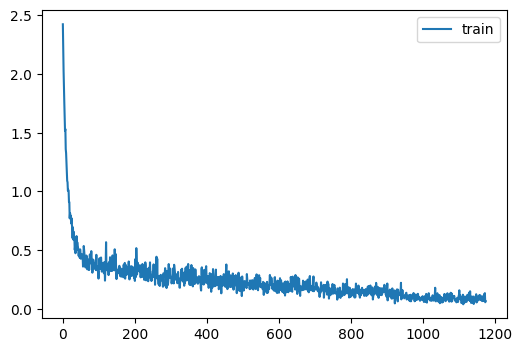

Fit 5 in: 37.64s, setup: 0.00s, 7.21 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [96]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0)

Batch size 256


accuracy,loss,epoch,train
0.868,0.543,0,train
0.877,0.394,0,eval
0.909,0.289,1,train
0.911,0.280,1,eval
0.930,0.208,2,train
0.918,0.232,2,eval
0.952,0.145,3,train
0.938,0.187,3,eval
0.975,0.083,4,train
0.941,0.184,4,eval


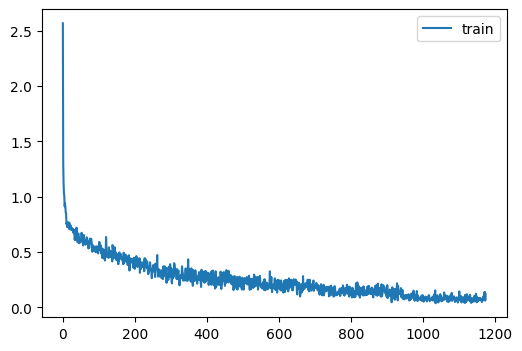

Fit 5 in: 91.79s, setup: 0.00s, 17.43 ± 0.07s per epoch, 0.07 ± 0.01s per batch


In [100]:
learn = run(**model9_ct())

Batch size 256


accuracy,loss,epoch,train
0.787,0.610,0,train
0.848,0.426,0,eval
0.868,0.359,1,train
0.869,0.373,1,eval
0.891,0.296,2,train
0.889,0.306,2,eval
0.909,0.242,3,train
0.900,0.283,3,eval
0.928,0.197,4,train
0.904,0.265,4,eval


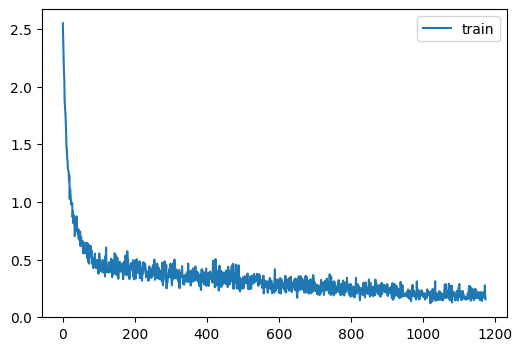

Fit 5 in: 9.12s, setup: 0.00s, 1.69 ± 0.01s per epoch, 0.01 ± 0.00s per batch


In [101]:
learn = run(**model_base_resnet())

## Curriculum learning on FP16

> It doesn't make a difference for fp16

Batch size 256


accuracy,loss,epoch,train
0.782,0.618,0,train
0.851,0.417,0,eval
0.867,0.361,1,train
0.868,0.346,1,eval
0.892,0.293,2,train
0.883,0.318,2,eval
0.911,0.238,3,train
0.900,0.276,3,eval
0.929,0.194,4,train
0.907,0.262,4,eval


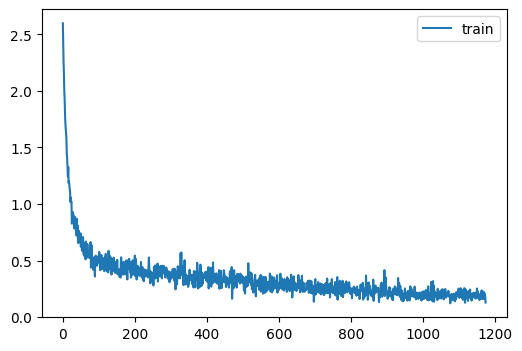

Fit 5 in: 10.03s, setup: 0.03s, 1.84 ± 0.11s per epoch, 0.01 ± 0.00s per batch


In [108]:
learn = run(**model_base_resnet(), dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0))

Batch size 256


accuracy,loss,epoch,train
0.865,0.553,0,train
0.879,0.389,0,eval
0.906,0.293,1,train
0.906,0.289,1,eval
0.930,0.207,2,train
0.924,0.221,2,eval
0.952,0.142,3,train
0.937,0.191,3,eval
0.976,0.080,4,train
0.940,0.187,4,eval


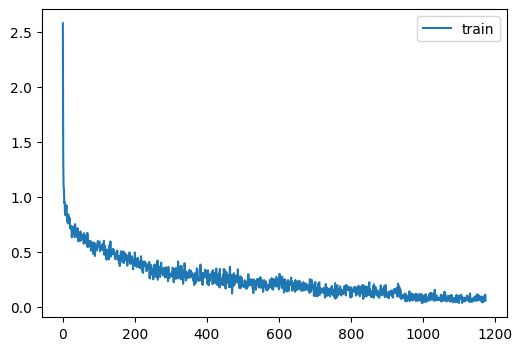

Fit 5 in: 92.71s, setup: 0.00s, 17.62 ± 0.12s per epoch, 0.07 ± 0.01s per batch


In [103]:
learn = run(**model9_ct(), dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0))

Batch size 256


accuracy,loss,epoch,train
0.834,0.479,0,train
0.851,0.434,0,eval
0.902,0.269,1,train
0.900,0.290,1,eval
0.925,0.205,2,train
0.915,0.233,2,eval
0.947,0.145,3,train
0.936,0.183,3,eval
0.967,0.093,4,train
0.942,0.173,4,eval


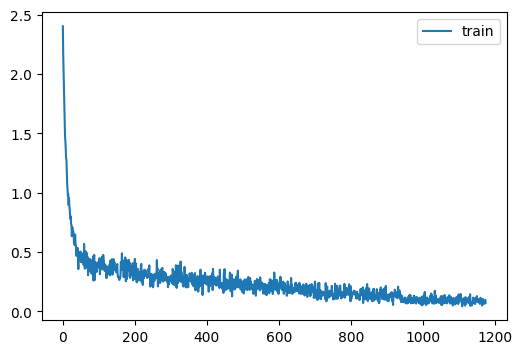

Fit 5 in: 38.09s, setup: 0.00s, 7.27 ± 0.12s per epoch, 0.03 ± 0.01s per batch


In [105]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0))

### TommyC OneCycleWithPlateau 

In [135]:
class OneCycleLRWithPlateau(lr_scheduler.OneCycleLR):
    def __init__(self, *args, pct_start=0.1, pct_plateau=0.2, **kwargs):
        kwargs["pct_start"] = pct_start
        super(OneCycleLRWithPlateau, self).__init__(*args, **kwargs)
        self._schedule_phases = [
            {
                'end_step': float(pct_start * self.total_steps) - 1,
                'start_lr': 'initial_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'max_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': float((pct_start + pct_plateau) * self.total_steps) - 2,
                'start_lr': 'max_lr',
                'end_lr': 'max_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'base_momentum',
            },
            {
                'end_step': self.total_steps - 1,
                'start_lr': 'max_lr',
                'end_lr': 'initial_lr',
                'start_momentum': 'base_momentum',
                'end_momentum': 'max_momentum',
            },
        ]

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.838,0.463,0,train
0.895,0.298,0,eval
0.911,0.246,1,train
0.891,0.301,1,eval
0.925,0.204,2,train
0.911,0.244,2,eval
0.945,0.151,3,train
0.933,0.186,3,eval
0.965,0.094,4,train
0.940,0.175,4,eval


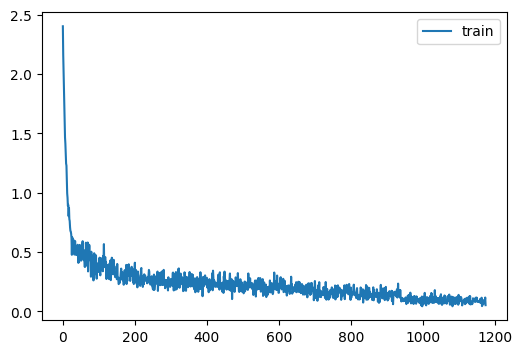

Fit 5 in: 37.64s, setup: 0.00s, 7.19 ± 0.18s per epoch, 0.03 ± 0.01s per batch


In [137]:
# lr=0.02, with Plateau
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            sched_fn=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.827,0.502,0,train
0.869,0.381,0,eval
0.912,0.239,1,train
0.913,0.238,1,eval
0.928,0.194,2,train
0.916,0.223,2,eval
0.949,0.140,3,train
0.933,0.188,3,eval
0.969,0.087,4,train
0.942,0.172,4,eval


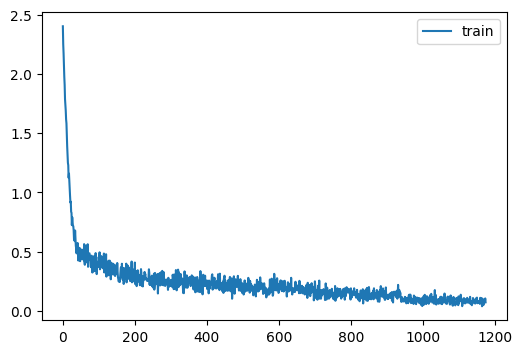

Fit 5 in: 38.09s, setup: 0.00s, 7.27 ± 0.14s per epoch, 0.03 ± 0.01s per batch


In [139]:
# lr=0.01 , with Plateau
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01,
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            sched_fn=partial(OneCycleLRWithPlateau, pct_start=0.1, pct_plateau=0.3))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.819,0.545,0,train
0.824,0.476,0,eval
0.902,0.265,1,train
0.909,0.255,1,eval
0.928,0.198,2,train
0.923,0.211,2,eval
0.949,0.140,3,train
0.934,0.188,3,eval
0.968,0.090,4,train
0.942,0.172,4,eval


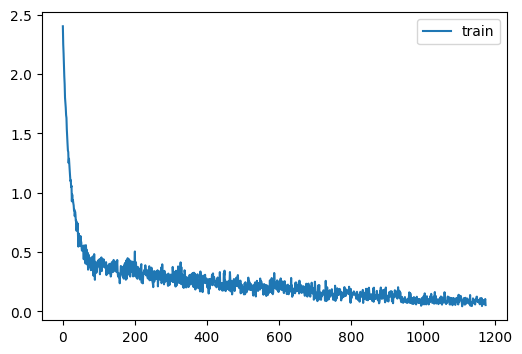

Fit 5 in: 38.49s, setup: 0.01s, 7.35 ± 0.26s per epoch, 0.03 ± 0.01s per batch


In [140]:
# lr=0.01
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01,
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.822,0.540,0,train
0.824,0.475,0,eval
0.904,0.263,1,train
0.914,0.244,1,eval
0.928,0.197,2,train
0.912,0.249,2,eval
0.948,0.141,3,train
0.931,0.192,3,eval
0.968,0.088,4,train
0.942,0.172,4,eval


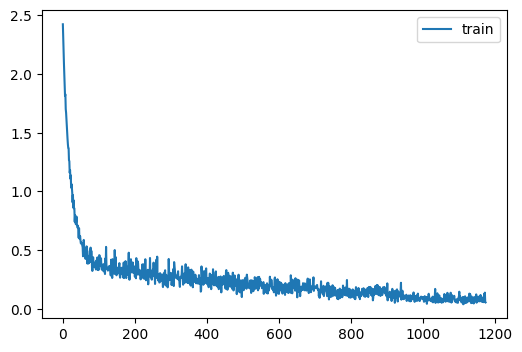

Fit 5 in: 37.17s, setup: 0.00s, 7.12 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [141]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), leaky=0.0, 
            base_lr=0.01)

### Mixup

In [111]:
from miniai.mixup import MixUpCB

In [113]:
class MixUpFP16CB(MixUpCB, AccelerateCB): pass

Batch size 256


accuracy,loss,epoch,train
0.775,1.212,0,train
0.873,0.555,0,eval
0.842,1.033,1,train
0.892,0.418,1,eval
0.864,0.977,2,train
0.917,0.323,2,eval
0.886,0.936,3,train
0.937,0.279,3,eval
0.907,0.898,4,train
0.944,0.259,4,eval


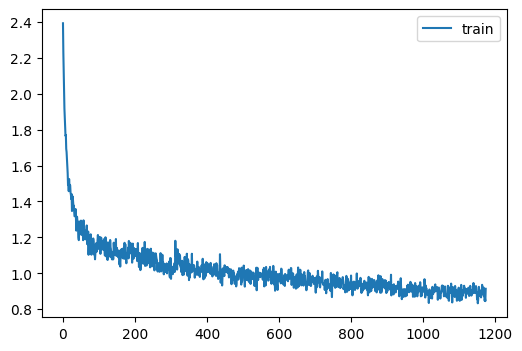

Fit 5 in: 39.19s, setup: 0.00s, 7.49 ± 0.13s per epoch, 0.03 ± 0.01s per batch


In [116]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.775,1.208,0,train
0.715,0.948,0,eval
0.845,1.032,1,train
0.903,0.392,1,eval
0.863,0.983,2,train
0.921,0.317,2,eval
0.884,0.936,3,train
0.930,0.294,3,eval
0.906,0.900,4,train
0.939,0.263,4,eval


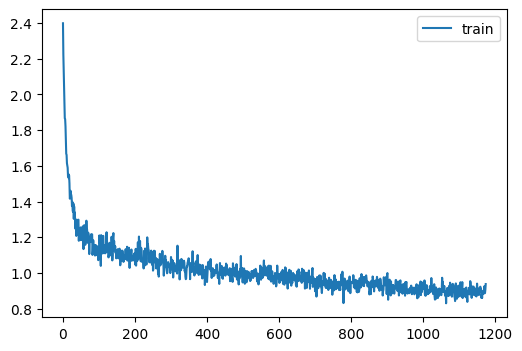

Fit 5 in: 37.70s, setup: 0.00s, 7.22 ± 0.15s per epoch, 0.03 ± 0.01s per batch


In [128]:
# no curriculum learning
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1))

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.767,0.924,0,train
0.757,0.834,0,eval
0.834,0.690,1,train
0.893,0.340,1,eval
0.855,0.620,2,train
0.917,0.252,2,eval
0.879,0.560,3,train
0.926,0.215,3,eval
0.900,0.514,4,train
0.940,0.174,4,eval


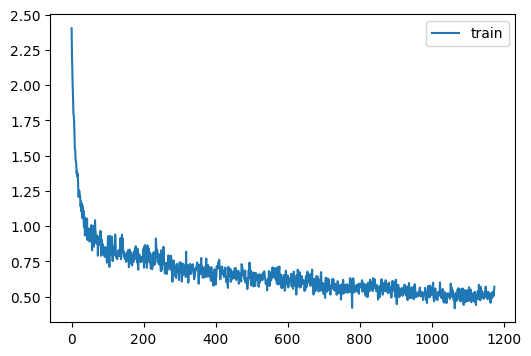

Fit 5 in: 37.83s, setup: 0.00s, 7.24 ± 0.10s per epoch, 0.03 ± 0.00s per batch


In [143]:
# no curriculum learning, no label smoothing
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.0))

### Mixup + Aug

In [148]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])
def augcb(*ag):
    tfms = nn.Sequential()
    return BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.739,1.284,0,train
0.824,0.568,0,eval
0.818,1.093,1,train
0.878,0.439,1,eval
0.843,1.023,2,train
0.899,0.373,2,eval
0.864,0.981,3,train
0.928,0.291,3,eval
0.880,0.947,4,train
0.933,0.274,4,eval


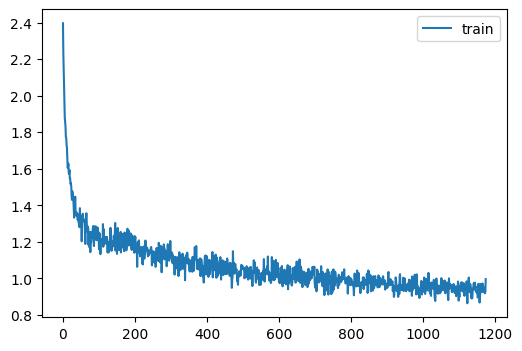

Fit 5 in: 39.14s, setup: 0.00s, 7.48 ± 0.18s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9352


In [131]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            dls=CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.743,1.279,0,train
0.819,0.560,0,eval
0.818,1.090,1,train
0.884,0.413,1,eval
0.842,1.029,2,train
0.902,0.359,2,eval
0.865,0.978,3,train
0.924,0.298,3,eval
0.882,0.944,4,train
0.932,0.271,4,eval


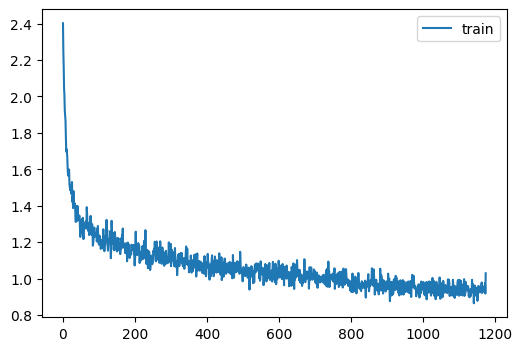

Fit 5 in: 38.57s, setup: 0.00s, 7.39 ± 0.15s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9347


In [142]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

# 20 ep

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.749,1.267,0,train
0.866,0.485,0,eval
0.819,1.103,1,train
0.875,0.443,1,eval
0.831,1.066,2,train
0.819,0.598,2,eval
0.842,1.036,3,train
0.893,0.393,3,eval
0.849,1.019,4,train
0.909,0.408,4,eval


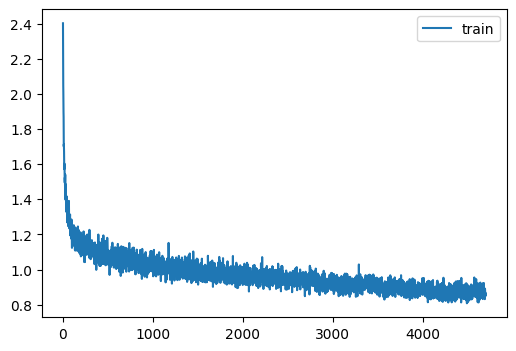

Fit 20 in: 153.54s, setup: 0.00s, 7.34 ± 0.07s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.953


In [146]:
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.767,2.259,0,train
0.863,0.544,0,eval
0.818,1.946,1,train
0.865,0.542,1,eval
0.825,1.865,2,train
0.908,0.434,2,eval
0.837,1.795,3,train
0.905,0.407,3,eval
0.844,1.760,4,train
0.870,0.549,4,eval


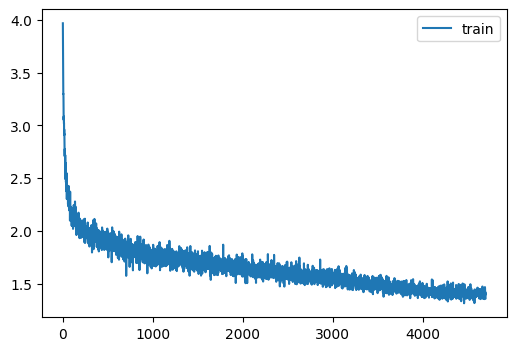

Fit 20 in: 159.55s, setup: 0.00s, 7.66 ± 0.08s per epoch, 0.03 ± 0.00s per batch
Reseed: 1
Reseed: 1
TTA: 0.87


In [150]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, loss_func=dmce, eta=0.1, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1


accuracy,loss,epoch,train
0.778,1.471,0,train
0.848,0.555,0,eval
0.836,1.278,1,train
0.902,0.409,1,eval
0.843,1.237,2,train
0.912,0.368,2,eval
0.854,1.199,3,train
0.914,0.364,3,eval
0.862,1.181,4,train
0.875,0.469,4,eval


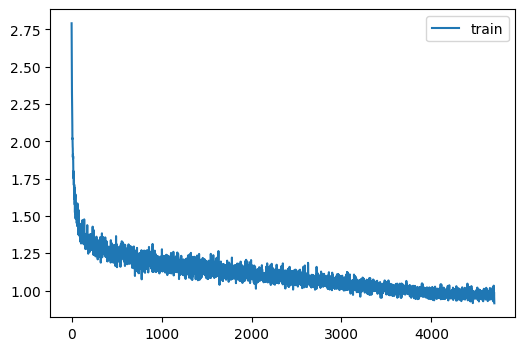

Fit 20 in: 159.23s, setup: 0.00s, 7.64 ± 0.11s per epoch, 0.03 ± 0.01s per batch
Reseed: 1
Reseed: 1
TTA: 0.9296


In [151]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=20,
            train_cb=MixUpFP16CB(0.4, use_prev=True, loss_func=dmce, eta=0.1/4, label_smoothing=0.1), tta=True)

In [147]:
### EP 50

In [ ]:
from miniai.mixup import dmce
learn = run(**timm_model('resnet18d', upscale32.bilinear(2)), 
            leaky=0.0, 
            cbs=[augcb(transforms.RandomCrop(28, padding=1),transforms.RandomHorizontalFlip(0.65))],
            epochs=50,
            train_cb=MixUpFP16CB(0.4, use_prev=True, eta=0.0, label_smoothing=0.1), tta=True)

Reseed: 1
Batch size 256
Reseed: 1
